Обработка страницы 256


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Метод isolate_dark_shades выполнен


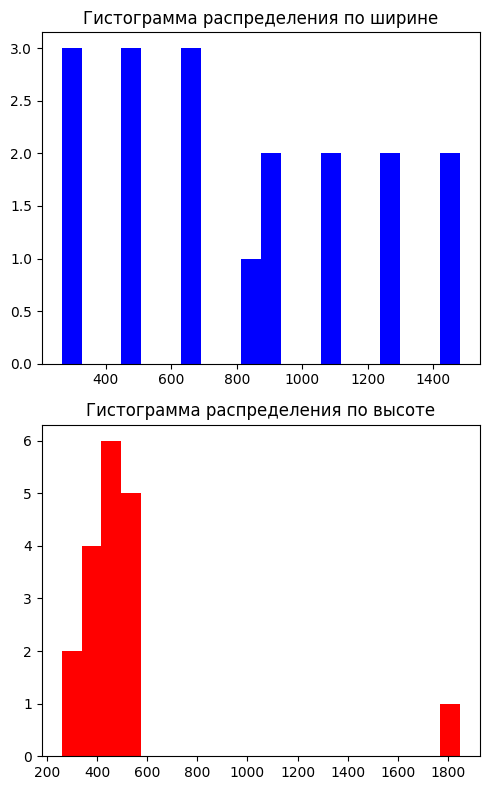

In [1]:
import pandas as pd
import easyocr 
import sys
import numpy as np
sys.path.append('C:/IDE/repository/liquid_vapor_database')
from src.table_gridlines import Gridlines
from src.pdf_image_extractor import PDFImageExtractor
from src.pdf_page_processor import PageImage
from src.page_data import PageData


PAGE_NUM = 256
data_path = f'C:/IDE/repository/liquid_vapor_database/data/Kogan_1.pdf'
work_folder_path = f'C:/IDE/repository/liquid_vapor_database/pdf_data/page_{PAGE_NUM}'
assets_folder_path = 'C:/IDE/repository/liquid_vapor_database/tests/assets'
img_path = f'{work_folder_path}/page_{PAGE_NUM}_processed.png'
extractor = PDFImageExtractor(data_path, work_folder_path)
page_image = PageImage(PAGE_NUM, extractor)
reader = easyocr.Reader(['ru', 'en'])
result = reader.readtext(img_path)
easyocr_df = pd.DataFrame(result, columns=['bbox','text','conf'])
detector = Gridlines(img_path, easyocr_df, debug=True)
page = PageData(easyocr_df)
page.df.to_csv(f'{assets_folder_path}/{PAGE_NUM}_df.csv', index=False)

In [11]:
from src.page_data import PageData


page = PageData(easyocr_df)

temp_df = page.df.query("region == 'value' and table_number == 1"
              ).drop(['region', 'table_number', 'prev_region', 'next_region'], axis=1)
temp_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
24,[8.2],[29.5],[],[],[],[],[],[],[],[],[],[],[]
25,[18.3],[51.4],[],[Нет данных],[],[4.1],[35.8],[63.8],[],[Нет данных],[],[7.8],[]
26,[46.5],[73.8],[],[],[],[],[59.2],[78.6],[],[],[],[],[]
27,[70.8],[85.8],[],[],[],[],[74.1],[86.5],[],[],[],[],[]
28,[87.8],[94.0],[],[],[],[],[10.4],[23.2],[],[],[],[11.2],[]
29,[6.0],[17.8],[],[],[],[],[20.1],[39.6],[],[],[],[],[]
30,[21.2],[47.1],[],[],[],[7.8],[41.9],[65.3],[],[],[],[],[]
31,[],[],[],[],[],[],[66.4],[81.7],[],[],[],[],[]


In [12]:
diff = page_image.max_height - page.max_y 
_min, _max = page.unscale_height_position(temp_df.index.min(), temp_df.index.max())

def adjust_min_max(_min, _max, bbox_mean):    
    if (_min_adjusted := _min - bbox_mean) < 0:
        _min_adjusted = 0
        
    _max_adjusted = (_max + bbox_mean)

    return _min_adjusted, _max_adjusted

adjusted_min, adjusted_max = adjust_min_max(
    _min, _max, page.data['bbox_height'].mean().astype('int'))

print("Adjusted Min:", adjusted_min)
print("Adjusted Max:", adjusted_max)

Adjusted Min: 934
Adjusted Max: 1409


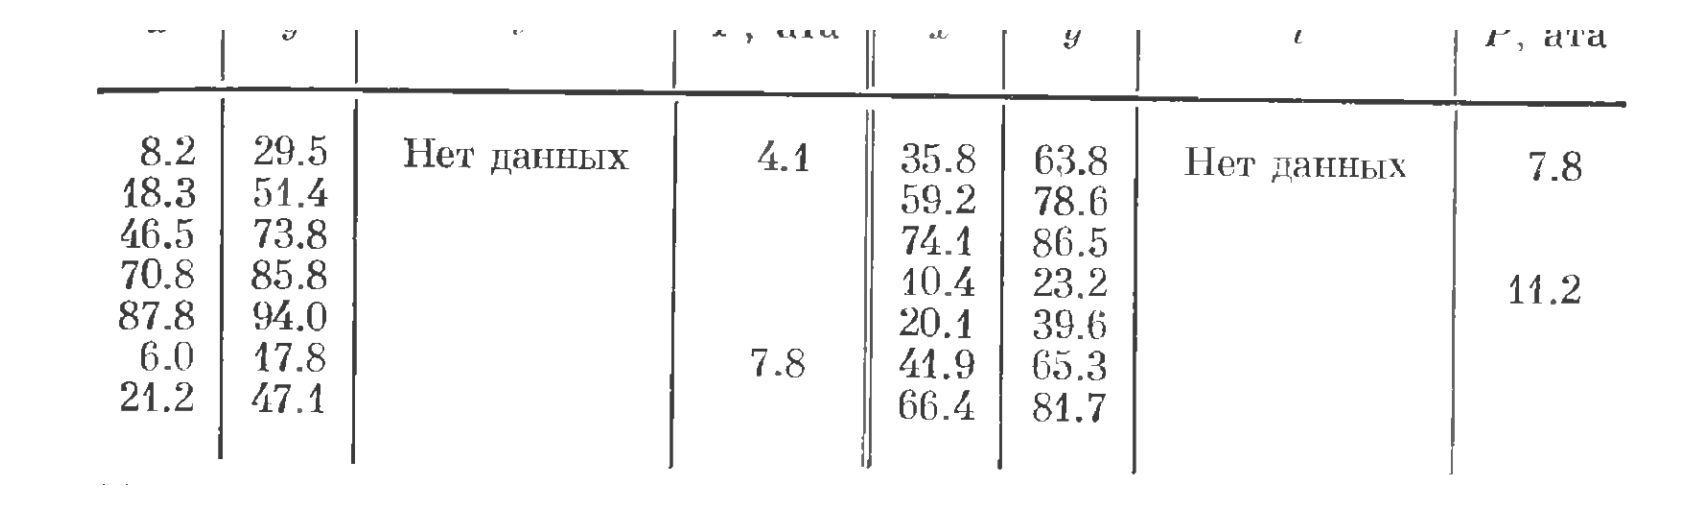

In [13]:
import matplotlib.pyplot as plt
import cv2


img = cv2.imread(img_path)

# Переключение цветовых каналов из BGR (формат OpenCV) в RGB (формат matplotlib).
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Обрезка изображения по высоте.
C = 0
cropped_img = img[adjusted_min - C:adjusted_max + C, :, :]

plt.figure(figsize=(7, 7), dpi=300)  
plt.imshow(cropped_img, interpolation='bilinear') 
plt.axis('off')
plt.show()

In [3]:
#page_image.min_width
page.unscale_height_position(temp_df.index.min(), temp_df.index.max())

(1704, 1960)

In [3]:
# Heatmap of bbox centers
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title('Heatmap of BBox Centers')
plt.xlabel('Scaled Position X')
plt.ylabel('Scaled Position Y')
plt.show()

ValueError: setting an array element with a sequence.

<Figure size 1000x600 with 0 Axes>

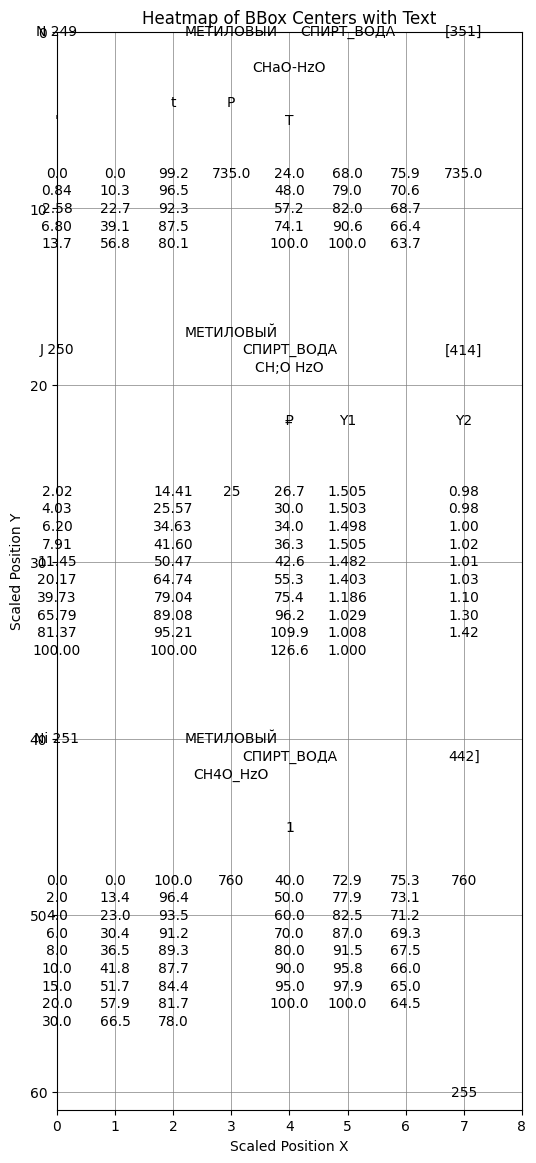

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Инициализация структуры данных для хранения текста
heatmap_data = np.empty((best_scale_y + 1, best_scale_x + 1), dtype=object)

# Заполнение пустыми строками или списками
for y in range(best_scale_y + 1):
    for x in range(best_scale_x + 1):
        heatmap_data[y, x] = []

# Обновление структуры данными из easyocr_df
for index, row in easyocr_df.iterrows():
    # Получаем координаты и текст для каждого bbox
    x = min(max(int(row['bbox_scale_position_x']), 0), best_scale_x)
    y = min(max(int(row['bbox_scale_position_y']), 0), best_scale_y)
    text = row['text']

    # Добавление текста в ячейку
    heatmap_data[y, x].append(text)

# Отображение тепловой карты
plt.figure(figsize=(6, 14))
for y in range(best_scale_y + 1):
    for x in range(best_scale_x + 1):
        if heatmap_data[y, x]:  # Если есть текст в этой ячейке
            plt.text(x, y, '\n'.join(heatmap_data[y, x]), ha='center', va='center')

plt.title('Heatmap of BBox Centers with Text')
# Построение сетки
plt.grid(True)  # Включить сетку
# Настройка сетки для лучшей визуализации
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.xlabel('Scaled Position X')
plt.ylabel('Scaled Position Y')
plt.xlim(0, best_scale_x)
plt.ylim(0, best_scale_y)
plt.gca().invert_yaxis()  # Инвертировать Y-ось для корректного отображения
plt.show()


In [3]:
df = pd.DataFrame(heatmap_data)
display(df.loc[18])


0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
5    0.0
6    0.0
7    1.0
Name: 18, dtype: float64

In [ ]:
import numpy as np

# Инициализация переменных для минимальных и максимальных значений
min_x, min_y = float('inf'), float('inf')
max_x, max_y = float('-inf'), float('-inf')

# Функция для обновления минимальных и максимальных значений
def update_min_max(bbox):
    global min_x, min_y, max_x, max_y
    for x, y in bbox:
        min_x = min(min_x, x)
        max_x = max(max_x, x)
        min_y = min(min_y, y)
        max_y = max(max_y, y)
        
# Функция для вычисления положения центра прямоугольника bbox и масштабирования его
def scale_position(bbox, scale_x, scale_y):
    center_x = sum([point[0] for point in bbox]) / 4
    center_y = sum([point[1] for point in bbox]) / 4
    scaled_x = scale_x * (center_x - min_x) / (max_x - min_x)
    scaled_y = scale_y * (center_y - min_y) / (max_y - min_y)
    return scaled_x, scaled_y

# Инициализируем переменные для лучшего решения
best_scale_x, best_scale_y = 1, 1
min_max_heatmap_value = float('inf')

# Определяем диапазон для поиска
scale_range = range(15, 100)  # Примерный диапазон, возможно потребуется настройка

for scale_x in scale_range:
    for scale_y in scale_range:
        # Вычисление масштабированных позиций
        scaled_positions = easyocr_df['bbox'].apply(
            lambda bbox: scale_position(bbox, scale_x, scale_y)
        ).tolist()

        # Корректировка координат в целые числа и обновление DataFrame
        scaled_x_positions, scaled_y_positions = zip(*scaled_positions)

        # Проверяем и обрабатываем NaN
        scaled_x_positions = [0 if np.isnan(x) else int(x) for x in scaled_x_positions]
        scaled_y_positions = [0 if np.isnan(y) else int(y) for y in scaled_y_positions]

        easyocr_df['bbox_scale_position_x'] = np.array(scaled_x_positions)
        easyocr_df['bbox_scale_position_y'] = np.array(scaled_y_positions)

        heatmap_data = np.zeros((scale_x, scale_y))  # Adjusted for the maximum scaled values in the sample
        for index, row in easyocr_df.iterrows():
            heatmap_data[row['bbox_scale_position_y'], row['bbox_scale_position_x']] += 1 

        # Определяем текущее максимальное значение в heatmap
        current_max_heatmap_value = np.max(heatmap_data)

        # Отладочный вывод текущего максимального значения в heatmap
        print(f"Текущие коэффициенты: Ширина = {scale_x}, Высота = {scale_y}, Текущий максимум heatmap = {current_max_heatmap_value}")

        # Обновляем лучшие коэффициенты, если текущее решение лучше и останавливаем, если достигнута цель
        if current_max_heatmap_value <= 1:
            best_scale_x, best_scale_y = scale_x, scale_y
            min_max_heatmap_value = current_max_heatmap_value
            print(f"Найдены оптимальные коэффициенты: Ширина = {best_scale_x}, Высота = {best_scale_y}")
            break  # Остановка внутреннего цикла
    if min_max_heatmap_value <= 1:
        break  # Остановка внешнего цикла

print(f"Оптимальные коэффициенты: Ширина = {best_scale_x}, Высота = {best_scale_y}")

In [26]:
heatmap_data = np.zeros((25, 50))  # Adjusted for the maximum scaled values in the sample
for index, row in easyocr_df.iterrows():
    heatmap_data[row['bbox_scale_position_y'], row['bbox_scale_position_x']] += 1 
    
heatmap_data


array([[159.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [ ]:
# Масштабирование линий к общей шкале bbox
def scale_lines(lines, min_val, max_val, scale_factor):
    return [(int(scale_factor * (x1 - min_val) / (max_val - min_val)),
             int(scale_factor * (y1 - min_val) / (max_val - min_val)),
             int(scale_factor * (x2 - min_val) / (max_val - min_val)),
             int(scale_factor * (y2 - min_val) / (max_val - min_val))) for x1, y1, x2, y2 in lines]

scaled_horizontal_gridlines = scale_lines(detector.horizontal_gridlines, min_y, max_y, 50)
scaled_vertical_gridlines = scale_lines(detector.vertical_gridlines, min_x, max_x, 25)

# Обновление функций подсчета линий для работы с масштабированными координатами
def count_scaled_lines_in_range(bbox, scaled_lines, coord_index):
    bbox_min = min(point[coord_index] for point in bbox)
    bbox_max = max(point[coord_index] for point in bbox)
    scaled_bbox_min = int(50 * (bbox_min - min_y) / (max_y - min_y)) if coord_index else int(25 * (bbox_min - min_x) / (max_x - min_x))
    scaled_bbox_max = int(50 * (bbox_max - min_y) / (max_y - min_y)) if coord_index else int(25 * (bbox_max - min_x) / (max_x - min_x))
    count = sum(1 for line in scaled_lines if scaled_bbox_min <= line[coord_index] <= scaled_bbox_max)
    return count

easyocr_df['horizontal_gridlines'] = easyocr_df['bbox'].apply(lambda bbox: count_scaled_lines_in_range(bbox, scaled_horizontal_gridlines, 1))
easyocr_df['vertical_gridlines'] = easyocr_df['bbox'].apply(lambda bbox: count_scaled_lines_in_range(bbox, scaled_vertical_gridlines, 0))

# Обновление grouped_data с новыми столбцами
grouped_data = grouped_data.join(
    easyocr_df.groupby(['bbox_scale_position_x', 'bbox_scale_position_y'])[['horizontal_gridlines', 'vertical_gridlines']].sum()
)

grouped_data['horizontal_gridlines']

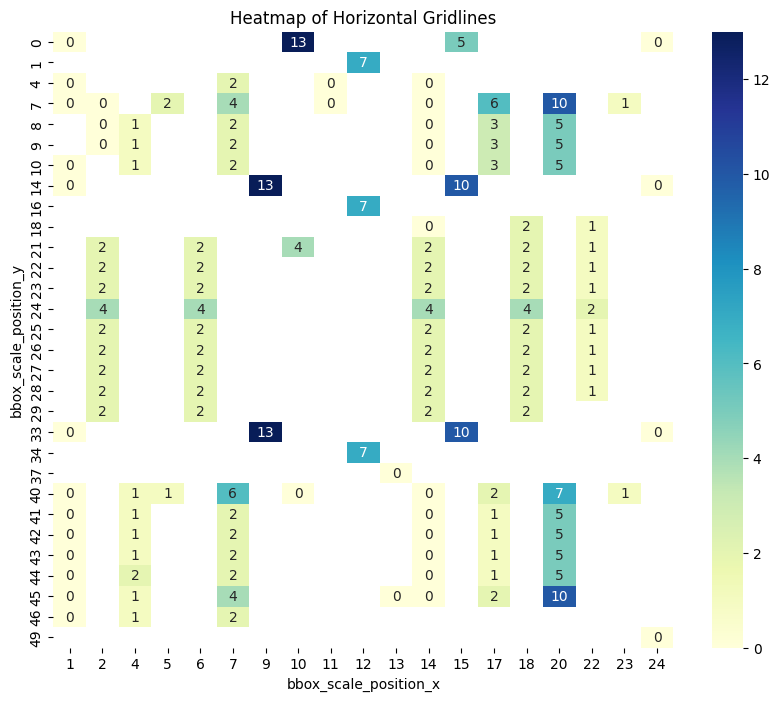

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Подготовка данных для тепловой карты
heatmap_data = easyocr_df.groupby(['bbox_scale_position_x', 'bbox_scale_position_y'])['vertical_gridlines'].sum().reset_index()
# Исправление ошибки с использованием pivot
heatmap_pivot = heatmap_data.pivot(index='bbox_scale_position_y', columns='bbox_scale_position_x', values='vertical_gridlines')

# Создание тепловой карты с исправленными данными
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_pivot, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title('Heatmap of Horizontal Gridlines')
plt.xlabel('bbox_scale_position_x')
plt.ylabel('bbox_scale_position_y')
plt.show()


In [34]:
def count_horizontal_lines_in_range(bbox):
    # Определение верхней и нижней границы bbox
    bbox_top = min(point[1] for point in bbox)
    bbox_bottom = max(point[1] for point in bbox)
    count = sum(1 for line in detector.horizontal_gridlines if bbox_top <= line[1] <= bbox_bottom)
    return count

def count_vertical_lines_in_range(bbox):
    # Определение левой и правой границы bbox
    bbox_left = min(point[0] for point in bbox)
    bbox_right = max(point[0] for point in bbox)
    count = sum(1 for line in detector.vertical_gridlines if bbox_left <= line[0] <= bbox_right)
    return count

# Применение новых функций
easyocr_df['horizontal_gridlines'] = easyocr_df['bbox'].apply(count_horizontal_lines_in_range)
easyocr_df['vertical_gridlines'] = easyocr_df['bbox'].apply(count_vertical_lines_in_range)

# Обновление grouped_data с новыми столбцами
grouped_data = grouped_data.join(
    easyocr_df.groupby('bbox_scale_position_y')[['horizontal_gridlines', 'vertical_gridlines']].sum()
)

grouped_data

,bbox_count,width_mean,height_mean,horizontal_gridlines,vertical_gridlines
bbox_scale_position_y,,,,,
1,15,88.466667,44.600000,0,0
2,13,102.461538,46.538462,0,20
4,11,89.181818,44.909091,0,7
5,3,74.666667,43.666667,0,0
6,10,113.300000,46.100000,0,20
7,15,87.800000,43.600000,0,28
9,2,316.000000,51.500000,0,12
10,3,148.000000,45.000000,0,13
11,2,75.000000,41.000000,0,0


In [24]:
detector.horizontal_gridlines

[(209, 1026, 1627, 1026),
 (114, 143, 1636, 143),
 (180, 892, 1631, 892),
 (26, 1872, 1625, 1872),
 (61, 290, 1638, 290),
 (23, 2011, 1626, 2011)]

In [6]:
# Define the path to the file
file_path = f'{work_folder_path}/{PAGE_NUM}_text.txt' 

# Update the clean_text function to remove the first character if it is a double quote and filter out empty lines after removal
def clean_text_updated(text):
    # Remove the first character if it's a double quote
    if text.startswith('"'):
        text = text[1:]
    # Replace unwanted characters
    text = text.replace("|", "").replace("]", "").replace(")", "").replace("}", "").replace("[", "")
    return text.strip()

try:
    # Re-read, clean, and filter the lines from the file using the updated logic
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    cleaned_lines = [clean_text_updated(line) for line in lines if clean_text_updated(line) != ""]
    df = pd.DataFrame(cleaned_lines, columns=['Text'])
    
    # Save the transformed file
    modified_file_path = f'{work_folder_path}/{PAGE_NUM}_text_modified.txt'
    df.to_csv(modified_file_path, index=False, header=True)
    modified_file_path  # Return the path to the modified file for confirmation
except Exception as e:
    response = str(e)
    response


# Clean each line and filter out empty lines
cleaned_lines = [clean_text_updated(line) for line in lines]

# Convert the cleaned lines into a DataFrame
df = pd.DataFrame(cleaned_lines, columns=['Text'])


In [8]:
# Extracting all x and y coordinates from bbox
x_coords = [x for bbox in easyocr_df['bbox'] for x, _ in bbox]
y_coords = [y for bbox in easyocr_df['bbox'] for _, y in bbox]

# Finding the min and max of x and y coordinates
min_x, max_x = min(x_coords), max(x_coords)
min_y, max_y = min(y_coords), max(y_coords)

min_x, max_x, min_y, max_y

(52, 1668, 54, 2658)

In [18]:
import numpy as np
import cv2
import re

img = cv2.imread(img_path)

# Определение размеров и создание пустого изображения для наложения
overlay = np.zeros_like(img)

def is_number(s):
    s = s.replace('_', '')  # Удалить нижние подчеркивания, если они есть
    try:
        float(s)  # для чисел с плавающей точкой
        return True
    except ValueError:
        return False

# Определить размеры изображения и разделить на _ частей по вертикали
height, width, _ = img.shape
section_height = height // 15

# Сортировать области по верхней координате Y
easyocr_df['top_y'] = easyocr_df['bbox'].apply(lambda x: x[0][1])  # Принимаем Y верхнего левого угла
easyocr_df = easyocr_df.sort_values(by='top_y')

# Статистика по секциям
section_density = []

# Инициализация счетчиков для каждой секции
for i in range(15):
    section_density.append({'text_count': 0, 'number_count': 0, 'min_y': i * section_height, 'max_y': (i+1) * section_height})

# Подсчет областей в каждой секции
for index, row in easyocr_df.iterrows():
    bbox = row['bbox']
    top_y = bbox[0][1]
    section_index = int(top_y // section_height)  # Приведение к int

    if section_index < 15:  # Защита от выхода за пределы списка
        if is_number(row['text']):
            section_density[section_index]['number_count'] += 1
        else:
            section_density[section_index]['text_count'] += 1

# Определение принадлежности секции и отрисовка прозрачных прямоугольников
alpha = 0.4  # Прозрачность прямоугольников
for i, section in enumerate(section_density):
    if section['text_count'] > section['number_count']:
        color = (0, 255, 255)  # Желтый для текста
    else:
        color = (255, 0, 0)  # Синий для чисел

    # Рисование прямоугольника на пустом изображении
    cv2.rectangle(overlay, (0, section['min_y']), (width, section['max_y']), color, -1)

# Определение горизонтальных линий имен столбцов
column_lines = detector.detect_column_names_area()  # [(x1, y1, x2, y2), ...]

# Смещение границы желтой области к линии в синей области
for line in column_lines:
    _, y, _, _ = line  # координаты Y линии

    # Определение, в какой секции находится линия
    for i, section in enumerate(section_density):
        if section['min_y'] <= y <= section['max_y']:
            # Если линия в синей области
            if section_density[i]['number_count'] > section_density[i]['text_count']:
                # Поиск ближайшей желтой области выше
                for j in range(i - 1, -1, -1):
                    if section_density[j]['text_count'] > section_density[j]['number_count']:
                        # Смещение границы желтой области к линии
                        section_density[j]['max_y'] = y
                        break

# Рисование обновленных прямоугольников на изображении
for section in section_density:
    if section['text_count'] > section['number_count']:
        color = (0, 255, 255)  # Желтый для текста
    else:
        color = (255, 0, 0)  # Синий для чисел

    cv2.rectangle(overlay, (0, section['min_y']), (img.shape[1], section['max_y']), color, -1)

# Наложение прозрачных прямоугольников
alpha = 0.4
cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

# Сохранить изображение
cv2.imwrite(img_path.replace('.png', '_adjusted_sections.png'), img)

True

In [15]:
import numpy as np
import cv2
import re

# Функция для проверки, является ли строка числом
def is_number(s):
    s = s.replace('_', '')
    try:
        float(s)
        return True
    except ValueError:
        return False

# Функция для сортировки секций
def sort_sections(df):
    df['top_y'] = df['bbox'].apply(lambda x: x[0][1])
    return df.sort_values(by='top_y')

# Функция для расчета плотности секций
def calculate_section_density(df, img_shape, section_height):
    section_density = []
    for i in range(15):
        section_density.append({'text_count': 0, 'number_count': 0, 'min_y': i * section_height, 'max_y': (i+1) * section_height})
    
    for index, row in df.iterrows():
        bbox = row['bbox']
        top_y = bbox[0][1]
        section_index = int(top_y // section_height)

        if section_index < 15:
            if is_number(row['text']):
                section_density[section_index]['number_count'] += 1
            else:
                section_density[section_index]['text_count'] += 1
    
    return section_density

# Функция для рисования прозрачных прямоугольников
def draw_overlay(img, section_density, alpha=0.4):
    overlay = np.zeros_like(img)
    yellow_coords = []  # Для координат желтых областей
    blue_coords = []  # Для координат синих областей

    for section in section_density:
        color = (0, 255, 255) if section['text_count'] > section['number_count'] else (255, 0, 0)
        coords = (0, section['min_y'], img.shape[1], section['max_y'])

        if section['text_count'] > section['number_count']:
            yellow_coords.append(coords)
        else:
            blue_coords.append(coords)

        cv2.rectangle(overlay, (coords[0], coords[1]), (coords[2], coords[3]), color, -1)

    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)
    return img, yellow_coords, blue_coords

# Функция для смещения границы секций
def adjust_for_column_lines(section_density, column_lines):    
    for line in column_lines:
        _, y, _, _ = line  # координаты Y линии
        # Определение, в какой секции находится линия
        for i, section in enumerate(section_density):
            if section['min_y'] <= y <= section['max_y']:
                # Если линия в синей области
                if section_density[i]['number_count'] > section_density[i]['text_count']:
                    # Поиск ближайшей желтой области выше
                    for j in range(i - 1, -1, -1):
                        if section_density[j]['text_count'] > section_density[j]['number_count']:
                            # Смещение границы желтой области к линии
                            section_density[j]['max_y'] = y
                            break
    return section_density

def can_be_merged(rect1, rect2):
    # Разбиваем координаты
    _, y1_1, _, y2_1 = rect1
    _, y1_2, _, y2_2 = rect2

    # Проверяем, соприкасаются ли прямоугольники по вертикали или находится ли один внутри другого
    vertical_touch = y2_1 == y1_2  # Изменено условие для точного соприкосновения
    vertical_overlap = (y1_1 < y2_2 and y2_1 > y1_2) or (y1_2 < y2_1 and y2_2 > y1_1)

    return vertical_touch or vertical_overlap

def merge_rectangles(coords):
    coords.sort(key=lambda x: x[1])
    merged_coords = []
    i = 0
    while i < len(coords) - 1:
        current = coords[i]
        next_rect = coords[i + 1]

        # Проверяем, можно ли объединить текущий и следующий прямоугольники
        if can_be_merged(current, next_rect):
            # Объединяем
            merged_rect = (current[0], current[1], next_rect[2], next_rect[3])
            # Проверяем, можно ли объединить следующий прямоугольник после текущего объединения
            i += 2  # Переходим к проверке следующего прямоугольника после следующего
            while i < len(coords) and can_be_merged(merged_rect, coords[i]):
                merged_rect = (merged_rect[0], merged_rect[1], coords[i][2], coords[i][3])
                i += 1
            merged_coords.append(merged_rect)
        else:
            merged_coords.append(current)
            i += 1

    # Добавляем последний прямоугольник, если он не был объединен
    if i == len(coords) - 1:
        merged_coords.append(coords[-1])

    return merged_coords

# Основная функция
def process_image(img_path, easyocr_df):
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    section_height = height // 15

    easyocr_df = sort_sections(easyocr_df)  # Исходя из предположения, что easyocr_df уже определен
    section_density = calculate_section_density(easyocr_df, img.shape, section_height)
    column_lines = detector.detect_column_names_area()  # Необходимо определить detector
    section_density = adjust_for_column_lines(section_density, column_lines)
    img, yellow_coords, blue_coords = draw_overlay(img, section_density)

    cv2.imwrite(img_path.replace('.png', '_adjusted_sections.png'), img)

    return merge_rectangles(yellow_coords), merge_rectangles(blue_coords)

# Вызов основной функции
yellow_coords, blue_coords = process_image(img_path, easyocr_df)


In [7]:
def can_be_merged(rect1, rect2):
    # Разбиваем координаты
    _, y1_1, _, y2_1 = rect1
    _, y1_2, _, y2_2 = rect2

    # Проверяем, соприкасаются ли прямоугольники по вертикали или находится ли один внутри другого
    vertical_touch = y2_1 == y1_2  # Изменено условие для точного соприкосновения
    vertical_overlap = (y1_1 < y2_2 and y2_1 > y1_2) or (y1_2 < y2_1 and y2_2 > y1_1)

    return vertical_touch or vertical_overlap

def merge_rectangles(coords):
    coords.sort(key=lambda x: x[1])
    merged_coords = []
    i = 0
    while i < len(coords) - 1:
        current = coords[i]
        next_rect = coords[i + 1]

        # Проверяем, можно ли объединить текущий и следующий прямоугольники
        if can_be_merged(current, next_rect):
            # Объединяем
            merged_rect = (current[0], current[1], next_rect[2], next_rect[3])
            # Проверяем, можно ли объединить следующий прямоугольник после текущего объединения
            i += 2  # Переходим к проверке следующего прямоугольника после следующего
            while i < len(coords) and can_be_merged(merged_rect, coords[i]):
                merged_rect = (merged_rect[0], merged_rect[1], coords[i][2], coords[i][3])
                i += 1
            merged_coords.append(merged_rect)
        else:
            merged_coords.append(current)
            i += 1

    # Добавляем последний прямоугольник, если он не был объединен
    if i == len(coords) - 1:
        merged_coords.append(coords[-1])

    return merged_coords

merged_blue_coords = merge_rectangles(yellow_coords)
for rect in merged_blue_coords:
    print(rect)

(0, 0, 1740, 1440)
(0, 1862, 1740, 2128)


In [16]:
def crop_and_save_image(image_path, rectangles, save_dir):
    # Загрузка изображения
    img = cv2.imread(image_path)
    if img is None:
        print("Ошибка загрузки изображения. Проверьте путь к изображению.")
        return

    # Обрезка и сохранение каждого прямоугольника
    for i, (x1, y1, x2, y2) in enumerate(rectangles):
        # Обрезка изображения согласно координатам
        crop_img = img[y1:y2, x1:x2]

        # Сохранение обрезанного изображения
        save_path = f"{save_dir}/cropped_{i+1}.png"
        cv2.imwrite(save_path, crop_img)
        print(f"Сохранено: {save_path}")

save_dir = 'C:/IDE/repository/liquid_vapor_database/pdf_data/page_133'       
crop_and_save_image(img_path, blue_coords, save_dir)

Сохранено: C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/cropped_1.png
Сохранено: C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/cropped_2.png
Сохранено: C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/cropped_3.png


In [16]:
img_path

'C:/IDE/repository/liquid_vapor_database/pdf_data/page_170/page_170_processed.png'

In [10]:
import pandas as pd

# easyocr_df - предположим, что это ваш DataFrame с результатами OCR

# Пересчитать координаты для более простого доступа
easyocr_df['x_min'] = easyocr_df['bbox'].apply(lambda bbox: bbox[0][0])
easyocr_df['y_min'] = easyocr_df['bbox'].apply(lambda bbox: bbox[0][1])
easyocr_df['x_max'] = easyocr_df['bbox'].apply(lambda bbox: bbox[2][0])
easyocr_df['y_max'] = easyocr_df['bbox'].apply(lambda bbox: bbox[2][1])

# Сортировка по Y, затем по X координатам
sorted_df = easyocr_df.sort_values(by=['y_min', 'x_min'])

# Группировка текста по строкам с учетом допуска в Y координатах
grouped_lines = {}
line_threshold = 10  # допуск в пикселях для Y координаты, чтобы считать тексты одной строки

for _, row in sorted_df.iterrows():
    added = False
    for y in grouped_lines:
        if abs(y - row['y_min']) < line_threshold:
            grouped_lines[y].append((row['x_min'], row['text']))
            added = True
            break
            
    if not added:
        grouped_lines[row['y_min']] = [(row['x_min'], row['text'])]

# Формирование итогового текста с пробелами, соответствующими расстоянию между словами
output_text = []
for y in sorted(grouped_lines.keys()):
    texts = sorted(grouped_lines[y], key=lambda x: x[0])
    line_text = ""
    last_x_end = 0
    for x, text in texts:
        space_count = max((x - last_x_end) // 20 - len(text), 0)  # количество пробелов между словами
        line_text += ' ' * space_count + text
        last_x_end = x + len(text) * 20  # обновление последнего x конца с учетом добавленного текста
    output_text.append(line_text)

# Сохраняем строки в текстовый файл
with open("output_text.txt", "w", encoding="utf-8") as file:
    for line in output_text:
        file.write(line + "\n")


TypeError: can't multiply sequence by non-int of type 'float'

In [15]:
import cv2
import numpy as np

# Замените это путем к вашему изображению
image_path = 'C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/page_133_processed.png'

# Загрузите изображение
img = cv2.imread(image_path)

# Предполагается, что easyocr_df - это ваш DataFrame
for index, row in easyocr_df.iterrows():
    bbox = row['bbox']
    text = row['text']

    # Находим координаты для текста: левый верхний угол и нижний правый
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    br = (int(br[0]), int(br[1]))

    # Установите параметры для текста: шрифт, размер и т.д.
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (0, 0, 255) # красный цвет
    font_thickness = 1

    # Нанесите текст на изображение
    img = cv2.putText(img, text, tl, font, font_scale, font_color, font_thickness, cv2.LINE_AA)

# Сохранить результат в файл
cv2.imwrite('C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/page_133_processed_easyocr.png', img)

True

In [17]:
easyocr_df['text'].to_list()

['Ni',
 '1(',
 'ВОДОРОД_МЕТАН',
 '[258]',
 'H2CH4',
 '?',
 '9',
 't',
 'Р, ата',
 'T',
 'Р , ата',
 '2.4',
 '96.8',
 '-182.7',
 '49',
 '6.4',
 '-163.0',
 '78',
 '3.6',
 '97.5',
 '76',
 '7.7',
 '94.2',
 '90',
 '5.0',
 '96.9',
 '102',
 '8.5',
 '93.6',
 '97',
 '6.4',
 '139',
 '8.7',
 '91.9',
 '103',
 '8.1',
 '96.8',
 '164',
 '11.1',
 '91.2',
 '138',
 '8.2',
 '96.4',
 '171',
 '11.9',
 '92.0',
 '141',
 '94.8',
 '206',
 '15.6',
 '91.0',
 '187',
 '9.7',
 '94,4',
 '221',
 '3.2',
 '86.9',
 '_151.0',
 '36',
 '94.7',
 '_169.9',
 '39',
 '6.3',
 '92.5',
 '77',
 '2.2',
 '96.4',
 '77',
 '9.2',
 '91.1',
 '96',
 '5.1',
 '96.1',
 '104',
 '9.9',
 '89.8',
 '112',
 '111',
 '11.6',
 '88.8',
 '140',
 '5.2',
 '7',
 '95.8',
 '146',
 '16.2',
 '87,7',
 '187',
 '10.5',
 '95.7',
 '175',
 '3.8',
 '85.5',
 '~146.0',
 '37',
 '13.8',
 '94.2',
 '234',
 '6.7',
 '87.4',
 '62',
 '3.3',
 '92.6',
 '_163.0',
 '32',
 '9.3',
 '89.3',
 '85',
 '4.2',
 '92.7',
 '49',
 '14.3',
 '86.9',
 '131',
 '5.8',
 '93.6',
 '66',
 'Ni',
 '11',